# Root fit analyzing neural network


By Brady Lowe

lowebra2@isu.edu

7/25/2018


This Jupyter notebook was written to both develope and explain how we can use
neural networks to analyze the output of root fits to raw data.

#### Load necessary packages

In [1]:
# Load some packages

# Keras packages for network
from keras.layers import Input, Dense, Activation, ZeroPadding2D, BatchNormalization
from keras.layers import AveragePooling2D, MaxPooling2D, Dropout, Conv2D, Flatten
from keras.models import Model
from keras.optimizers import Adam, SGD
# For saving model
from keras.models import model_from_json

# Some items for plotting and drawing
from keras.utils import plot_model
from keras.utils.vis_utils import model_to_dot
from IPython.display import SVG
from PIL import Image
from scipy import misc
import matplotlib.pyplot as plt

# Need numpy
import numpy as np
import nn_utils as utils

%matplotlib inline

# Define image file path
im_path="/media/data/Projects/fit_pmt/images/png_fit_nn/"

Using TensorFlow backend.


#### Load root fit data from file

In [2]:
# Load images
m = 100
dataset = "train"
x = utils.load_images(m=m, dataset=dataset, log_scale=False, im_path=im_path)
m, h, w, c = x.shape
input_shape = h, w, c
print(str(m) + " images loaded of shape " + str(input_shape))

# Load labels
y = utils.load_labels(m=m, dataset=dataset)
print(str(y.shape[0]) + " labels loaded")

21 images loaded of shape (236, 348, 3)
21 labels loaded


In [3]:
# Load images
m_dev = m / 5
dataset = "dev"
x_dev = utils.load_images(m=m_dev, dataset=dataset, log_scale=False, im_path=im_path)
m_dev = x_dev.shape[0]
print(str(m_dev) + " images loaded of shape " + str(input_shape))

# Load labels
y_dev = utils.load_labels(m=m_dev, dataset=dataset)
print(str(y_dev.shape[0]) + " labels loaded")

3 images loaded of shape (236, 348, 3)
3 labels loaded


### Print an image

label: good
label: [1]


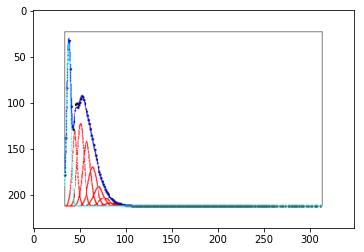

In [4]:
# Print an image
index = 7
this_image = x[index]
if y[index] == 1:
    print("label: good")
else:
    print("label: bad")
print("label: " + str(y[index]))
plt.imshow(np.uint8(utils.get_printable_image(this_image)))

## Define and Train 3 layer ConvNet with 2 fully connected layers plus output layer

For the convolutional layer, we will scan over our images with a certain stride and a certain kernal size. 
Each individual scan represents a single neuron in the next layer. Since each scan connects to kernal size squared
neurons below it, convolutions reduce the number of degrees of freedom. Hopefully, through learning the right filters,
we can preserve the important information as we reduce it in size.

Once the image has gone through the convolutional layers (and therefore has been reduced to its features vector), we
can send the resulting vector into some old-fashioned fully-connected layers, and finally into a logistic regression unit.

##### Define hyperparameters

In [5]:
# Initialize
filters = []
kernels = []
strides = []
pools = []
dropouts = []

# Conv1
filters.append(16)
kernels.append(5)
strides.append(2)
pools.append(2)
dropouts.append(0.4)

# Conv2
filters.append(64)
kernels.append(5)
strides.append(2)
pools.append(2)
dropouts.append(0.4)

# Conv3
filters.append(256)
kernels.append(3)
strides.append(2)
pools.append(2)
dropouts.append(0.2)

# Conv4
filters.append(1024)
kernels.append(3)
strides.append(1)
pools.append(1)
dropouts.append(0.2)

# Define dense (fully-connected) layer sizes
fc1 = 30
fc2 = 30

##### Define keras layers (model)

In [6]:
# Define input layer (RGB image matrix)
X = Input(shape=input_shape, name='Input')

# Initialize activation as input
a = X
# Loop through all convolutional layers
for i in range(len(filters)):
    # Perform convolution
    a = Conv2D(filters=filters[i], kernel_size=(kernels[i], kernels[i]), strides=(strides[i], strides[i]), name=('conv' + str(i)))(a)
    # Normalize
    a = BatchNormalization(axis=3, name=('bn' + str(i)))(a)
    # Activate
    a = Activation('relu', name=('a' + str(i)))(a)
    # Max-pool
    a = MaxPooling2D((pools[i], pools[i]), name=('max_pool' + str(i)))(a)
    # Dropout
    a = Dropout(rate=dropouts[i])(a)

# Flatten output of convNet
a = Flatten()(a)
# Define first fully connected layer
a = Dense(units=fc1, activation='relu', name='fc0')(a)
# Use some dropout here for regularization
a = Dropout(rate=0.2)(a)
# Define second fully connected layer
a = Dense(units=fc2, activation='relu', name='fc1')(a)
# Define output layer 
a = Dense(units=1, activation='sigmoid', name='sigmoid')(a)

# Make the model
model = Model(inputs=X, outputs=a)

##### Define optimizer, loss, and metrics. Compile model.

In [7]:
# Define optimizer
#opt = Adam(lr=0.01, beta_1=0.9, beta_2=0.999, decay=0.001)
opt = SGD(lr=1.0, decay=1e-6, momentum=0.9, nesterov=True)
# Define loss
loss = 'mean_squared_error'
# Define metrics to use
metrics=['acc']
# Compile model
model.compile(loss=loss, optimizer='sgd', metrics=metrics)
# Print summary
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Input (InputLayer)           (None, 236, 348, 3)       0         
_________________________________________________________________
conv0 (Conv2D)               (None, 116, 172, 16)      1216      
_________________________________________________________________
bn0 (BatchNormalization)     (None, 116, 172, 16)      64        
_________________________________________________________________
a0 (Activation)              (None, 116, 172, 16)      0         
_________________________________________________________________
max_pool0 (MaxPooling2D)     (None, 58, 86, 16)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 58, 86, 16)        0         
_________________________________________________________________
conv1 (Conv2D)               (None, 27, 41, 64)        25664     
__________

##### Fit the model to the data (train)

Train on 21 samples, validate on 3 samples
Epoch 1/200
21/21 [==============================] - 1s 43ms/step - loss: 0.4121 - acc: 0.2381 - val_loss: 0.3795 - val_acc: 0.0000e+00
Epoch 2/200
21/21 [==============================] - 0s 4ms/step - loss: 0.2747 - acc: 0.4286 - val_loss: 0.2935 - val_acc: 0.3333
Epoch 3/200
21/21 [==============================] - 0s 4ms/step - loss: 0.2154 - acc: 0.7143 - val_loss: 0.2024 - val_acc: 1.0000
Epoch 4/200
21/21 [==============================] - 0s 4ms/step - loss: 0.1627 - acc: 0.7619 - val_loss: 0.1179 - val_acc: 1.0000
Epoch 5/200
21/21 [==============================] - 0s 4ms/step - loss: 0.0597 - acc: 1.0000 - val_loss: 0.0923 - val_acc: 1.0000
Epoch 6/200
21/21 [==============================] - 0s 4ms/step - loss: 0.0964 - acc: 0.9048 - val_loss: 0.0674 - val_acc: 1.0000
Epoch 7/200
21/21 [==============================] - 0s 4ms/step - loss: 0.0400 - acc: 1.0000 - val_loss: 0.0496 - val_acc: 1.0000
Epoch 8/200
21/21 [================

Epoch 63/200
21/21 [==============================] - 0s 4ms/step - loss: 9.8735e-04 - acc: 1.0000 - val_loss: 0.0025 - val_acc: 1.0000
Epoch 64/200
21/21 [==============================] - 0s 4ms/step - loss: 6.7884e-04 - acc: 1.0000 - val_loss: 0.0025 - val_acc: 1.0000
Epoch 65/200
21/21 [==============================] - 0s 4ms/step - loss: 0.0013 - acc: 1.0000 - val_loss: 0.0025 - val_acc: 1.0000
Epoch 66/200
21/21 [==============================] - 0s 3ms/step - loss: 6.8130e-04 - acc: 1.0000 - val_loss: 0.0025 - val_acc: 1.0000
Epoch 67/200
21/21 [==============================] - 0s 4ms/step - loss: 0.0085 - acc: 1.0000 - val_loss: 0.0023 - val_acc: 1.0000
Epoch 68/200
21/21 [==============================] - 0s 4ms/step - loss: 0.0077 - acc: 1.0000 - val_loss: 0.0023 - val_acc: 1.0000
Epoch 69/200
21/21 [==============================] - 0s 4ms/step - loss: 0.0032 - acc: 1.0000 - val_loss: 0.0022 - val_acc: 1.0000
Epoch 70/200
21/21 [==============================] - 0s 4ms/ste

Epoch 125/200
21/21 [==============================] - 0s 4ms/step - loss: 3.9855e-04 - acc: 1.0000 - val_loss: 9.1985e-04 - val_acc: 1.0000
Epoch 126/200
21/21 [==============================] - 0s 4ms/step - loss: 0.0014 - acc: 1.0000 - val_loss: 9.1672e-04 - val_acc: 1.0000
Epoch 127/200
21/21 [==============================] - 0s 4ms/step - loss: 8.0603e-04 - acc: 1.0000 - val_loss: 9.1044e-04 - val_acc: 1.0000
Epoch 128/200
21/21 [==============================] - 0s 4ms/step - loss: 9.7045e-04 - acc: 1.0000 - val_loss: 9.0745e-04 - val_acc: 1.0000
Epoch 129/200
21/21 [==============================] - 0s 4ms/step - loss: 6.3730e-04 - acc: 1.0000 - val_loss: 9.0452e-04 - val_acc: 1.0000
Epoch 130/200
21/21 [==============================] - 0s 4ms/step - loss: 9.1215e-04 - acc: 1.0000 - val_loss: 9.0078e-04 - val_acc: 1.0000
Epoch 131/200
21/21 [==============================] - 0s 4ms/step - loss: 4.9960e-04 - acc: 1.0000 - val_loss: 8.9666e-04 - val_acc: 1.0000
Epoch 132/200
21/

21/21 [==============================] - 0s 4ms/step - loss: 1.6334e-04 - acc: 1.0000 - val_loss: 5.3862e-04 - val_acc: 1.0000
Epoch 185/200
21/21 [==============================] - 0s 3ms/step - loss: 1.9830e-04 - acc: 1.0000 - val_loss: 5.3879e-04 - val_acc: 1.0000
Epoch 186/200
21/21 [==============================] - 0s 3ms/step - loss: 0.0015 - acc: 1.0000 - val_loss: 5.4021e-04 - val_acc: 1.0000
Epoch 187/200
21/21 [==============================] - 0s 3ms/step - loss: 0.0014 - acc: 1.0000 - val_loss: 5.3577e-04 - val_acc: 1.0000
Epoch 188/200
21/21 [==============================] - 0s 3ms/step - loss: 3.9281e-04 - acc: 1.0000 - val_loss: 5.3295e-04 - val_acc: 1.0000
Epoch 189/200
21/21 [==============================] - 0s 3ms/step - loss: 0.0018 - acc: 1.0000 - val_loss: 5.3066e-04 - val_acc: 1.0000
Epoch 190/200
21/21 [==============================] - 0s 4ms/step - loss: 1.9127e-04 - acc: 1.0000 - val_loss: 5.2942e-04 - val_acc: 1.0000
Epoch 191/200
21/21 [==================

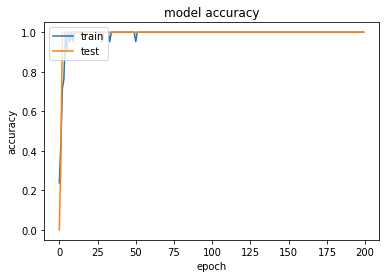

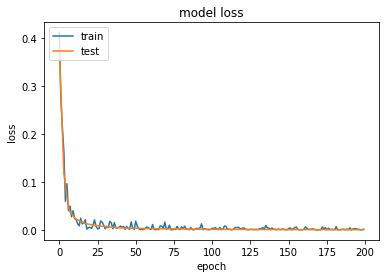

In [13]:
# Now, fit the model to the data
history = model.fit(x, y, validation_data=(x_dev, y_dev), epochs=200, batch_size=32)
# List all data in history
print(history.history.keys())
# Summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# Summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

##### Load pretrained conv model

In [9]:
# load json and create model
json_file = open('trained/conv_model_quickngood.json', 'r')
conv_model_json = json_file.read()
json_file.close()
model = model_from_json(conv_model_json)
# load weights into new model
model.load_weights("trained/conv_model_quickngood.h5")
print("Loaded model from disk")

Loaded model from disk


##### Additional model evaluation

In [14]:
x_val, y_val = x, y
# Evaluate model, get metrics back
stats = model.evaluate(x_val, y_val)
# Calculate predictions vector from model
predictions = model.predict(x_val)
predictions = np.floor(predictions + 0.5)

# Get vector mask for good and bad fits and right and wrong answers
good_fits = y_val
bad_fits = 1 - good_fits
wrong_answers = np.abs(np.subtract(predictions, good_fits))
right_answers = np.subtract(1, wrong_answers)
# Calculate true positives (tp), as well as (tn) (fp) (fn)
true_positives = np.multiply(right_answers, good_fits)
true_negatives = np.multiply(right_answers, bad_fits)
false_positives = np.multiply(wrong_answers, good_fits)
false_negatives = np.multiply(wrong_answers, bad_fits)
# Calculate additional metrics
precision = np.sum(true_positives) / np.sum(true_positives + false_positives)
recall = np.sum(true_positives) / np.sum(true_positives + false_negatives)

# Print stats
print()
print("Performance on VALIDATION set")
print(".............................")
print("Loss: " + str(stats[0]))
print("Accuracy: " + str(stats[1]))
print("Precision: " + str(precision))
print("Recall: " + str(recall))

# Print list of indices of wrong answers
bad_list = []
for i in range(m_dev):
    if wrong_answers[i] == 1:
        bad_list.append(i)
print(".............................")
print("List of indices of wrong guesses:")
print(bad_list)

21/21 [==============================] - 0s 2ms/step

Performance on VALIDATION set
.............................
Loss: 0.0008666993235237896
Accuracy: 1.0
Precision: 1.0
Recall: 1.0
.............................
List of indices of wrong guesses:
[]


##### Look at an image

label: [1]
prediction: [1.]
(236, 348, 3)


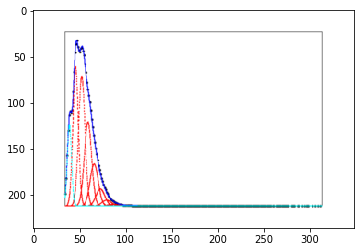

In [15]:
# Choose an index 
index = 2

# Print labels for this index
print("label: " + str(good_fits[index]))
print("prediction: " + str(predictions[index]))

# Show image
this_image = x[index]
print(str(this_image.shape))
plt.imshow(np.uint8(utils.get_printable_image(this_image)))

##### Save convolutional model to disc

In [12]:
#plot_model(simple_model, to_file='simple_model.png')
#SVG(model_to_dot(simple_model).create(prog='dot', format='svg'))

# serialize model to JSON
model_json = model.to_json()
with open("trained/conv_model_quickngood_2000epoch_sql_log.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("trained/conv_model_quickngood_2000epoch_sql_log.h5")
print("Saved model to disk")

Saved model to disk
